In [31]:
# CELL 1: IMPORTS & ENVIRONMENT CHECK

import os
import re
import time
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models import Word2Vec

print("Working directory:", os.getcwd())
print("Data directory:", os.listdir("../data"))


Matplotlib is building the font cache; this may take a moment.


Working directory: c:\MLT1_text-classification\notebooks
Data directory: ['glove.6B.100D.txt', 'pricerunner_aggregate.csv']


In [9]:
# CELL 2: LOAD DATASET

df = pd.read_csv("../data/pricerunner_aggregate.csv")
df = df.dropna(subset=["Product Title", " Category Label"])

texts = df["Product Title"].astype(str).values
labels = df[" Category Label"].values

print("Samples:", len(texts))


Samples: 35311


In [3]:
# CELL 3: LABEL ENCODING

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

num_classes = len(np.unique(y))
print("Number of classes:", num_classes)


Number of classes: 10


In [10]:
# CELL 4: PREPROCESSING

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return " ".join(text.split())

texts_clean = [clean_text(t) for t in texts]


In [11]:
# CELL 5: TRAIN / TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    texts_clean,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", len(X_train), "Test:", len(X_test))


Train: 28248 Test: 7063


In [15]:
# CELL 6: METRIC FUNCTION

def evaluate_and_save(model_name, embedding, y_true, y_pred, train_time):
    results = {
        "model": model_name,
        "embedding": embedding,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "train_time_sec": round(train_time, 2)
    }

    output_dir = "../outputs/tables"
    os.makedirs(output_dir, exist_ok=True)
    path = f"{output_dir}/results_lstm_{embedding.lower()}.json"
    with open(path, "w") as f:
        json.dump(results, f, indent=2)

    return results


In [16]:
# CELL 7: TF-IDF + LSTM

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

model_tfidf = Sequential([
    Dense(256, activation="relu", input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model_tfidf.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

start = time.time()
model_tfidf.fit(
    X_train_tfidf,
    y_train,
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)
time_tfidf = time.time() - start

pred_tfidf = np.argmax(model_tfidf.predict(X_test_tfidf), axis=1)
results_tfidf = evaluate_and_save("LSTM", "TF-IDF", y_test, pred_tfidf, time_tfidf)


Epoch 1/10
883/883 [==============================] - 12s 13ms/step - loss: 0.4679 - accuracy: 0.9018
Epoch 2/10
883/883 [==============================] - 11s 12ms/step - loss: 0.0936 - accuracy: 0.9755
Epoch 3/10
883/883 [==============================] - 11s 12ms/step - loss: 0.0623 - accuracy: 0.9817
Epoch 4/10
883/883 [==============================] - 11s 13ms/step - loss: 0.0505 - accuracy: 0.9840
Epoch 5/10
883/883 [==============================] - 11s 13ms/step - loss: 0.0454 - accuracy: 0.9843
Epoch 6/10
883/883 [==============================] - 11s 13ms/step - loss: 0.0420 - accuracy: 0.9851
Epoch 7/10
883/883 [==============================] - 11s 13ms/step - loss: 0.0399 - accuracy: 0.9851
Epoch 8/10
883/883 [==============================] - 11s 13ms/step - loss: 0.0381 - accuracy: 0.9851
Epoch 9/10
883/883 [==============================] - 12s 13ms/step - loss: 0.0367 - accuracy: 0.9852
Epoch 10/10
221/221 [==============================] - 1s 2ms/step


In [17]:
# CELL 8: TOKENIZATION

tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

def tokenize(texts):
    return pad_sequences(
        tokenizer.texts_to_sequences(texts),
        maxlen=20,
        padding="post"
    )

X_train_seq = tokenize(X_train)
X_test_seq = tokenize(X_test)

vocab_size = len(tokenizer.word_index) + 1
sentences = [t.split() for t in X_train]


In [18]:
# CELL 9: SKIP-GRAM + LSTM

w2v_sg = Word2Vec(sentences, vector_size=100, window=5, min_count=2, sg=1)

emb_sg = np.zeros((vocab_size, 100))
for w, i in tokenizer.word_index.items():
    if w in w2v_sg.wv:
        emb_sg[i] = w2v_sg.wv[w]

model_sg = Sequential([
    Embedding(vocab_size, 100, weights=[emb_sg], input_length=20, trainable=False),
    LSTM(128),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model_sg.compile("adam", "sparse_categorical_crossentropy", ["accuracy"])

start = time.time()
model_sg.fit(
    X_train_seq,
    y_train,
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)
time_sg = time.time() - start

pred_sg = np.argmax(model_sg.predict(X_test_seq), axis=1)
results_sg = evaluate_and_save("LSTM", "Skipgram", y_test, pred_sg, time_sg)


Epoch 1/10
883/883 [==============================] - 13s 13ms/step - loss: 0.3735 - accuracy: 0.8747
Epoch 2/10
883/883 [==============================] - 11s 13ms/step - loss: 0.1986 - accuracy: 0.9328
Epoch 3/10
883/883 [==============================] - 11s 13ms/step - loss: 0.1750 - accuracy: 0.9416
Epoch 4/10
883/883 [==============================] - 11s 13ms/step - loss: 0.1628 - accuracy: 0.9452
Epoch 5/10
883/883 [==============================] - 11s 13ms/step - loss: 0.1518 - accuracy: 0.9477
Epoch 6/10
883/883 [==============================] - 11s 13ms/step - loss: 0.1415 - accuracy: 0.9503
Epoch 7/10
883/883 [==============================] - 11s 13ms/step - loss: 0.1317 - accuracy: 0.9544
Epoch 8/10
883/883 [==============================] - 13s 15ms/step - loss: 0.1300 - accuracy: 0.9554
Epoch 9/10
883/883 [==============================] - 13s 15ms/step - loss: 0.1228 - accuracy: 0.9567
Epoch 10/10
221/221 [==============================] - 2s 6ms/step


In [19]:
# CELL 10: CBOW + LSTM

w2v_cbow = Word2Vec(sentences, vector_size=100, window=5, min_count=2, sg=0)

emb_cbow = np.zeros((vocab_size, 100))
for w, i in tokenizer.word_index.items():
    if w in w2v_cbow.wv:
        emb_cbow[i] = w2v_cbow.wv[w]

model_cbow = Sequential([
    Embedding(vocab_size, 100, weights=[emb_cbow], input_length=20, trainable=False),
    LSTM(128),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model_cbow.compile("adam", "sparse_categorical_crossentropy", ["accuracy"])

start = time.time()
model_cbow.fit(
    X_train_seq,
    y_train,
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)
time_cbow = time.time() - start

pred_cbow = np.argmax(model_cbow.predict(X_test_seq), axis=1)
results_cbow = evaluate_and_save("LSTM", "CBOW", y_test, pred_cbow, time_cbow)


Epoch 1/10
883/883 [==============================] - 12s 12ms/step - loss: 0.3871 - accuracy: 0.8715
Epoch 2/10
883/883 [==============================] - 11s 12ms/step - loss: 0.2267 - accuracy: 0.9247
Epoch 3/10
883/883 [==============================] - 11s 13ms/step - loss: 0.2044 - accuracy: 0.9311
Epoch 4/10
883/883 [==============================] - 13s 15ms/step - loss: 0.1948 - accuracy: 0.9329
Epoch 5/10
883/883 [==============================] - 13s 14ms/step - loss: 0.1791 - accuracy: 0.9373
Epoch 6/10
883/883 [==============================] - 13s 14ms/step - loss: 0.1697 - accuracy: 0.9398
Epoch 7/10
883/883 [==============================] - 13s 15ms/step - loss: 0.1642 - accuracy: 0.9414
Epoch 8/10
883/883 [==============================] - 13s 15ms/step - loss: 0.1540 - accuracy: 0.9441
Epoch 9/10
883/883 [==============================] - 14s 15ms/step - loss: 0.1466 - accuracy: 0.9474
Epoch 10/10
221/221 [==============================] - 2s 6ms/step


In [29]:
# CELL 11: GLOVE + LSTM

glove_path = "../data/glove.6B.100d.txt"

if not os.path.exists(glove_path):
    raise FileNotFoundError(
        "GloVe file not found at ../data/glove.6B.100d.txt. "
        "Download glove.6B.zip from https://nlp.stanford.edu/projects/glove/ "
        "and extract glove.6B.100d.txt into the data folder."
    )

glove = {}
glove_dim = None
with open(glove_path, encoding="utf8") as f:
    for line in f:
        v = line.split()
        vec = np.asarray(v[1:], dtype="float32")
        if glove_dim is None:
            glove_dim = len(vec)
            print(f"Detected GloVe dimension: {glove_dim}")
        glove[v[0]] = vec

emb_glove = np.zeros((vocab_size, glove_dim))
for w, i in tokenizer.word_index.items():
    if w in glove:
        emb_glove[i] = glove[w]

model_glove = Sequential([
    Embedding(vocab_size, glove_dim, weights=[emb_glove], input_length=20, trainable=False),
    LSTM(128),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model_glove.compile("adam", "sparse_categorical_crossentropy", ["accuracy"])

start = time.time()
model_glove.fit(
    X_train_seq,
    y_train,
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)
time_glove = time.time() - start

pred_glove = np.argmax(model_glove.predict(X_test_seq), axis=1)
results_glove = evaluate_and_save("LSTM", "GloVe", y_test, pred_glove, time_glove)


Detected GloVe dimension: 300
Epoch 1/10
883/883 [==============================] - 53s 56ms/step - loss: 0.3912 - accuracy: 0.8680
Epoch 2/10
883/883 [==============================] - 49s 56ms/step - loss: 0.2022 - accuracy: 0.9326
Epoch 3/10
883/883 [==============================] - 53s 60ms/step - loss: 0.1737 - accuracy: 0.9412
Epoch 4/10
883/883 [==============================] - 53s 60ms/step - loss: 0.1554 - accuracy: 0.9456
Epoch 5/10
883/883 [==============================] - 33s 38ms/step - loss: 0.1382 - accuracy: 0.9510
Epoch 6/10
883/883 [==============================] - 25s 28ms/step - loss: 0.1359 - accuracy: 0.9520
Epoch 7/10
883/883 [==============================] - 22s 25ms/step - loss: 0.1241 - accuracy: 0.9556
Epoch 8/10
883/883 [==============================] - 22s 25ms/step - loss: 0.1266 - accuracy: 0.9540
Epoch 9/10
883/883 [==============================] - 22s 25ms/step - loss: 0.1123 - accuracy: 0.9605
Epoch 10/10
221/221 [==============================]

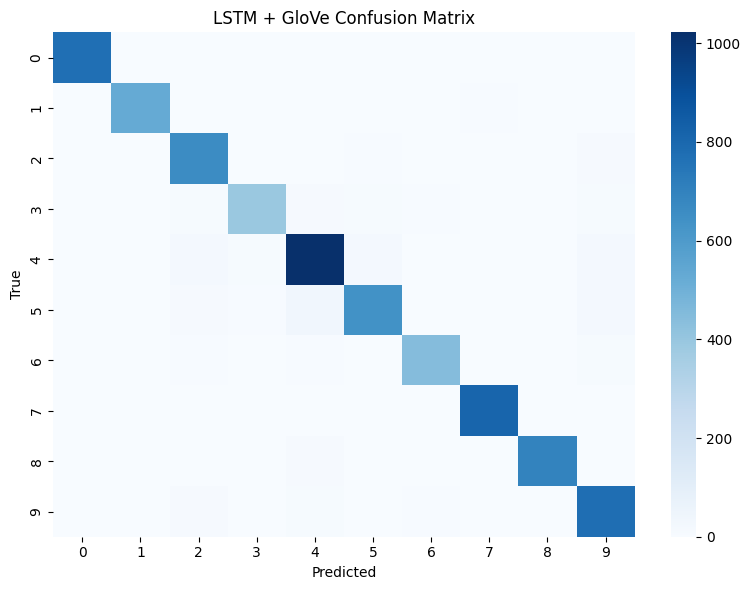

In [32]:
# CELL 12: CONFUSION MATRIX (BEST EMBEDDING)

cm = confusion_matrix(y_test, pred_glove)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, cmap="Blues", cbar=True)
plt.title("LSTM + GloVe Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
os.makedirs("../outputs/figures", exist_ok=True)
plt.savefig("../outputs/figures/lstm_glove_confusion_matrix.png", dpi=300)
plt.show()


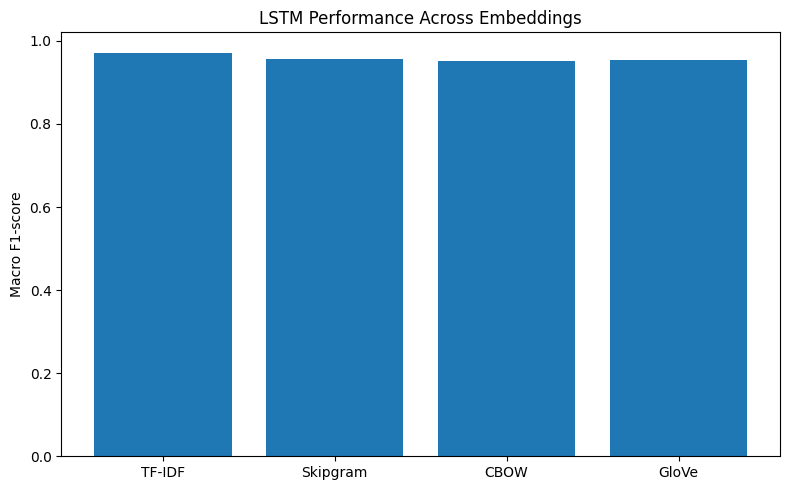

In [33]:
# CELL 13: MACRO F1 COMPARISON

embeddings = ["TF-IDF", "Skipgram", "CBOW", "GloVe"]
f1s = [
    results_tfidf["f1_macro"],
    results_sg["f1_macro"],
    results_cbow["f1_macro"],
    results_glove["f1_macro"]
]

plt.figure(figsize=(8, 5))
plt.bar(embeddings, f1s)
plt.ylabel("Macro F1-score")
plt.title("LSTM Performance Across Embeddings")
plt.tight_layout()
os.makedirs("../outputs/figures", exist_ok=True)
plt.savefig("../outputs/figures/lstm_f1_comparison.png", dpi=300)
plt.show()


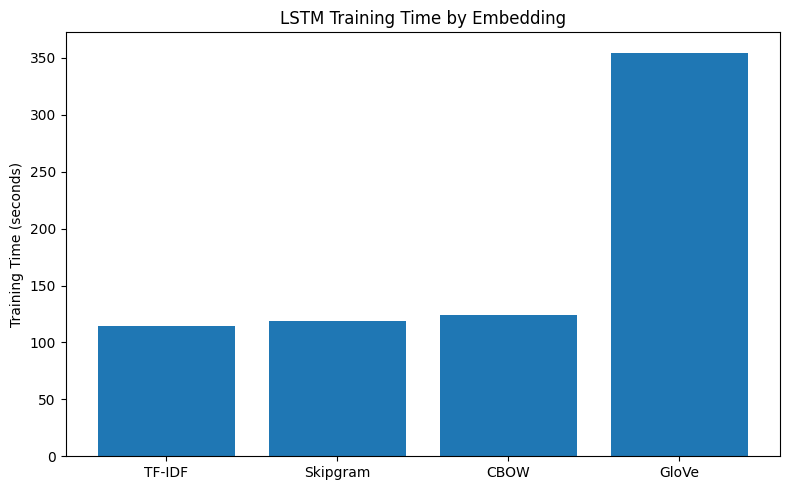

In [34]:
# CELL 14: TRAINING TIME COMPARISON

times = [
    results_tfidf["train_time_sec"],
    results_sg["train_time_sec"],
    results_cbow["train_time_sec"],
    results_glove["train_time_sec"]
]

plt.figure(figsize=(8, 5))
plt.bar(embeddings, times)
plt.ylabel("Training Time (seconds)")
plt.title("LSTM Training Time by Embedding")
plt.tight_layout()
os.makedirs("../outputs/figures", exist_ok=True)
plt.savefig("../outputs/figures/lstm_training_time.png", dpi=300)
plt.show()
